In [1]:
import os
import csv
import pandas as pd
import numpy as np
import importlib
import formulaEvo
importlib.reload(formulaEvo)
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

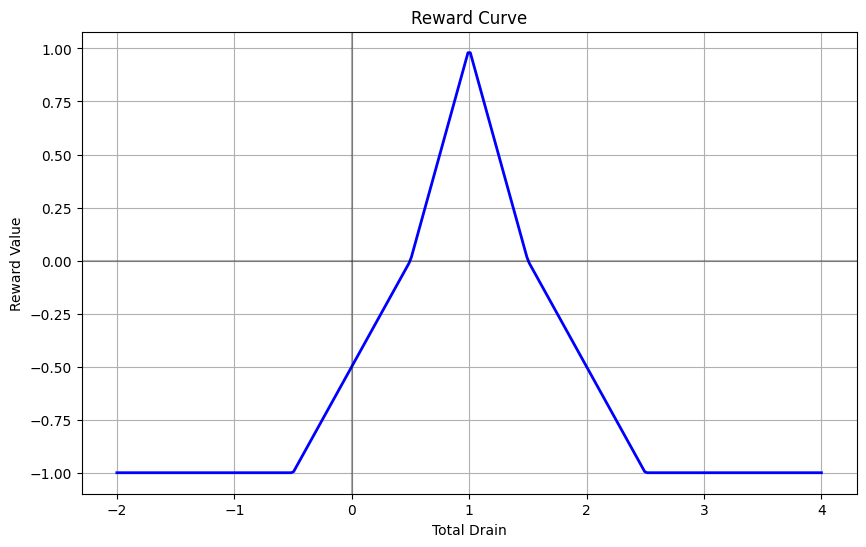

In [2]:
#Mögliche verbesserung:
#desto weiter er zum bewässerungszeitpunkt kommt dsestro schlechter wird der reward bei konstantem Drain ofsett



def make_reward_curve(irriAmount, total_drain, samples):
    if samples == 0:
        return []
    
    idealdrain = 0.2 * irriAmount # ideal drain is 20% of irrigation amount
    allowPercent = 0.1 * irriAmount# allow 10% deviation from ideal drain

    reward = np.array([-1,-1,0,1,0,-1,-1])
    drain = np.array([-1,-0.5, idealdrain - allowPercent, idealdrain, idealdrain + allowPercent, 2.5, 3])
    SplineFit = UnivariateSpline(drain, reward, s=0, k=1)
    # Create curve with same reward value for all samples
    reward_value = SplineFit(total_drain)
    reward_curve = [reward_value] * samples
    return reward_curve

# Plot the function from -0.5 to 2.5
x_values = np.linspace(-2, 4, 300)
y_values = []

for x in x_values:
    y_values.append(make_reward_curve(5, x, 1)[0])

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('Total Drain')
plt.ylabel('Reward Value')
plt.title('Reward Curve')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.show()


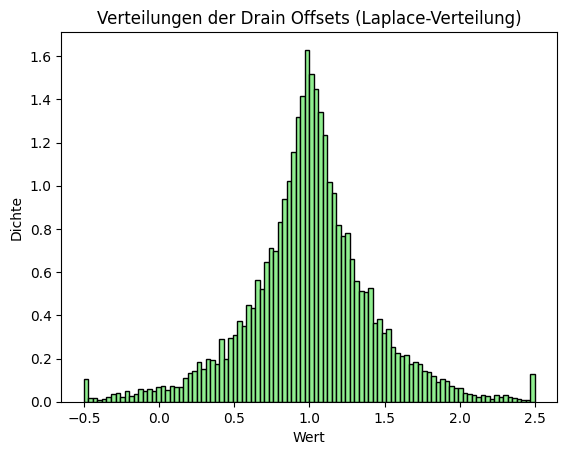

In [3]:
def getDrainOffset():
    sample = np.random.laplace(loc=1.0, scale=0.3)
    sample = np.clip(sample, -0.5, 2.5)
    return sample

samples_laplace = []
for _ in range(10000):
    samples_laplace.append(getDrainOffset())

# Plot
plt.hist(samples_laplace, bins=100, density=True, color='lightgreen', edgecolor='black')
plt.title("Verteilungen der Drain Offsets (Laplace-Verteilung)")
plt.xlabel("Wert")
plt.ylabel("Dichte")
plt.show()

In [4]:
def getCSVData(csvfile):
    print(f"Processing file: {csvfile}")
    fileData = pd.read_csv(csvfile, sep=';', decimal=',')
    fileData = fileData.iloc[2:].reset_index(drop=True)  # Remove first 2 lines

    stationData = {}

    stationData['time'] = pd.to_datetime(fileData['TIMESTAMP'], format='%d.%m.%Y %H:%M')
    stationData['temp'] = fileData['AirTC_Avg'].astype(str).str.replace(',', '.').astype(float)
    stationData['humi'] = fileData['RH_Avg'].astype(str).str.replace(',', '.').astype(float)
    stationData['light'] = (fileData['SlrW_Avg'].astype(str).str.replace(',', '.').astype(float)*10*60)/1000000  # von W/m² zu Ws/m² (10min Mittelwert), dann zu MJ/m²

    #NAN werte ersetzten und finden
    for key in stationData: 
        # Finde NaN-Positionen vor dem Füllen
        nan_positions = stationData[key].isnull()
        if nan_positions.any():
            nan_indices = nan_positions[nan_positions].index.tolist()
            print(f"NaN values found in {key} at positions: {nan_indices}")
            print(f"Total NaN values in {key}: {nan_positions.sum()}")
        
        stationData[key] = stationData[key].ffill(limit=1)
        
        # Prüfe nach dem Füllen auf verbleibende NaN-Werte
        remaining_nan = stationData[key].isnull()
        if remaining_nan.any():
            remaining_indices = remaining_nan[remaining_nan].index.tolist()
            print(f"Remaining NaN values in {key} after forward fill at positions: {remaining_indices}")
            raise ValueError(f"More than one NaN value in a row in {key} detected at positions: {remaining_indices}")

    # Trenne data in einzelne Tage auf
    stationDays = []
    n = 0
    for day, group in pd.DataFrame(stationData).groupby(pd.to_datetime(stationData['time']).dt.date):
        #lasse nur daten von Kalenderwoche 18 bis 39 zu
        if day.strftime('%W') >= '18' and day.strftime('%W') <= '39':
            #rohdaten der groupe überprüfen auf lücken
            stationDays.append({
                'date': day,
                'temp_diff_day': max(group['temp'].to_numpy()) - min(group['temp'].to_numpy()),
                'time': group['time'],
                'temp': group['temp'].to_numpy(),
                'light': group['light'].to_numpy(),
                'humi': group['humi'].to_numpy()
            })

    #Erechnen der täglichen Temperartur Differenz
    temp_avg_year = np.mean([day['temp_diff_day'] for day in stationDays])
    print(f"Average daily temperature difference from Tepfenhardt data: {temp_avg_year:.2f} °C")

    #Analysiere die Evaporationen
    for day in stationDays:
        evaporation = formulaEvo.calculate_evaporation_solar(
            day['date'],
            day['temp_diff_day'],
            formulaEvo.krKorean(temp_avg_year),
            day['light']
        )
        day['evo'] = evaporation
    return stationDays


def seconds_since_midnight(timestamps):
    """Gibt die Tageszeit in Sekunden (0-86400) für ein datetime-Objekt zurück."""
    midnight = timestamps.dt.normalize()
    return (timestamps - midnight).dt.total_seconds()

def make_drain_curve(total_drain, samples):
    # nach 10 min 70%
    # nach 20 min 90%
    # nach 30 min 100%
    # erstellt eine Drainkurve in der Länge der Episoden samples
    if total_drain < 0: #darin unter kleiner 0 ist kein drain
        return [0]*samples
    values = [0, 0.7*total_drain, 0.9*total_drain]
    # Schneide oder fülle auf die gewünschte Länge
    if samples <= len(values):
        return values[:samples]
    else:
        values += [total_drain] * (samples - len(values))
        return values
    
def split_day_by_evo(day, threshold=5.0):
    #episode auschneiden länge = 5l(ideal)+ Überschuss Drain in l([-0,75,+2]l)
    #dann wert von Überschusss (+-2l) durch ausgleichskurve in Drainkurve umwandeln
    # nach 10 min 70%
    # nach 20 min 90%
    # nach 30 min 100%
    """
    Teilt jeden Tag in tepfi_days in Episoden, sodass jede Episode ca. threshold mm (z.B. 2mm) kumulierte Verdunstung enthält.
    Jede Episode enthält die kompletten Wertearrays (temp, humi, light, etc.) für den jeweiligen Abschnitt.
    Rückgabe: Liste von Episoden, jede Episode ist ein Dict mit den Feldern wie ein Tag, aber nur für den Episodenbereich.
    """
    episodes = []
    evo = np.asarray(day['evo'])
    cumsum = np.cumsum(evo)
    start_idx = 0
    last_cum = cumsum[0] if len(cumsum) > 0 else 0
    drain = getDrainOffset()
    threshold_total = threshold + drain  # füge zufälligen Überschuss hinzu
    if 'date' in day:
        del day['date']
    if 'temp_diff_day' in day:
        del day['temp_diff_day']
    for i in range(1, len(evo)):
        if cumsum[i] - last_cum >= threshold_total:
            epi = {}
            for key in day:
                epi[key] = day[key][start_idx:i]
            epi['drain'] = make_drain_curve(drain, i - start_idx)
            epi['reward'] = make_reward_curve(5,drain, i - start_idx)
            episodes.append(epi)
            start_idx = i
            last_cum = cumsum[i]
            new_drain = getDrainOffset()
            threshold_total = threshold + new_drain  # neuer zufälliger Überschuss
    # letzte Episode bis zum Ende
    if start_idx < len(evo):
        epi = {}
        for key in day:
            epi[key] = day[key][start_idx:]
        episodes.append(epi)
    return episodes

#save Episodes from data
def save_Episode(baseFolder, month, day, station, episodes):
    if not os.path.exists(baseFolder):
        os.makedirs(baseFolder)

    for i, epi in enumerate(episodes):
        fileName = os.path.join(baseFolder, f"{station}-{month}-{day}-Epi{i}.csv")
        with open(fileName, "w", newline="") as file:
            writer = csv.writer(file)
            for j in range(len(epi['time'])):
                observation = [
                    epi['doy'],
                    epi['abstime'][j],
                    epi['time'][j],
                    epi['temp'][j],
                    epi['humi'][j],
                    epi['light'][j],
                    epi['drain'][j],
                    epi['timeToIrri'][j],
                    epi['reward'][j]
                ]
                writer.writerow(observation)

In [5]:
csvfolder = "../CSV AgrarMeteo"
savePath = "../episFormula/3. corrected sign"
episodenAll = []

for csvfile in os.listdir(csvfolder):
    if csvfile.endswith(".csv"):
        csvfileFull = os.path.join(csvfolder, csvfile)
        stationDays = getCSVData(csvfileFull)
        for day in stationDays:
            epiDay = split_day_by_evo(day, threshold=5.0)
            episodenRaw = epiDay[1:-1]  # ggf. [1:-1] für Episodenfilter
            episoden = []
            for epiRaw in episodenRaw:
                episode = {}
                episode['doy'] = pd.Timestamp(epiRaw['time'].iloc[0]).dayofyear
                episode['abstime'] = np.array(seconds_since_midnight(epiRaw['time']))/60  # in Minuten
                episode['time'] = np.array((epiRaw['time'] - epiRaw['time'].iloc[0]).dt.total_seconds())/60  # in Minuten
                episode['temp'] = np.array(epiRaw['temp'])
                episode['humi'] = np.array(epiRaw['humi'])
                episode['light'] = epiRaw['light'].cumsum()
                episode['timeToIrri'] = np.array((epiRaw['time'].iloc[-1] - epiRaw['time']).dt.total_seconds())/60  # in Minuten
                episode['drain'] = np.array(epiRaw['drain'])
                episode['reward'] = np.array(epiRaw['reward'])
                episoden.append(episode)
            episodenAll.append(episoden)
            month = pd.Timestamp(day['time'].iloc[0]).month
            daynum = pd.Timestamp(day['time'].iloc[0]).day
            # Remove .csv extension from filename
            station_name = csvfile[:-4]  # Remove last 4 characters (.csv)
            save_Episode(savePath, str(month), str(daynum), station_name, episoden)

Processing file: ../CSV AgrarMeteo\Bavendorf.csv


C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_2256\775864974.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21,22,23,24,25,30,31,32,36,37,38,39,40,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  fileData = pd.read_csv(csvfile, sep=';', decimal=',')


NaN values found in light at positions: [72360, 73941, 75092, 127653, 230608, 231761, 236811]
Total NaN values in light: 7
Average daily temperature difference from Tepfenhardt data: 12.16 °C
Processing file: ../CSV AgrarMeteo\Kleintobel.csv


C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_2256\775864974.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,27,30,31,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  fileData = pd.read_csv(csvfile, sep=';', decimal=',')


NaN values found in temp at positions: [120859, 121464, 121466]
Total NaN values in temp: 3
NaN values found in light at positions: [22681, 27718, 72504, 121464, 122334, 122477, 227970, 228833, 230135, 275495, 288470]
Total NaN values in light: 11
Average daily temperature difference from Tepfenhardt data: 13.57 °C
Processing file: ../CSV AgrarMeteo\Tepfenhardt.csv


C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_2256\775864974.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,27,30,31,32,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  fileData = pd.read_csv(csvfile, sep=';', decimal=',')


NaN values found in light at positions: [17641, 22962, 74085, 127801, 128229, 174310]
Total NaN values in light: 6
Average daily temperature difference from Tepfenhardt data: 12.50 °C
